# Chapter 11 Working with Unlabeled Data - Clustering Analysis

- Finding centers of similarity using the pupolar k-means algorithm
- Using a bottom-up approach to build hierarchical cluster trees
- Identifying arbitrary shapes of objects using a density-based clustering approach

## Grouping objects by similarity using k-means

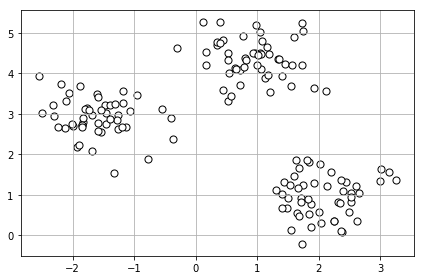

In [20]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=150, 
                  n_features=2, 
                  centers=3, 
                  cluster_std=0.5, 
                  shuffle=True, 
                  random_state=0)
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c='white', marker='o', s=50, edgecolors='black', linewidths=1)
plt.grid()
plt.tight_layout()
plt.show()

### Classic K-means

In [32]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3,
            init='random',
            n_init=10,
            max_iter=300,
            tol=1e-04,
           random_state=0)
y_km = km.fit_predict(X)
km.cluster_centers_

array([[ 0.9329651 ,  4.35420712],
       [ 2.06521743,  0.96137409],
       [-1.5947298 ,  2.92236966]])

### K-means++

In [33]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
           random_state=0)
y_km = km.fit_predict(X)
km.cluster_centers_

array([[ 2.06521743,  0.96137409],
       [-1.5947298 ,  2.92236966],
       [ 0.9329651 ,  4.35420712]])

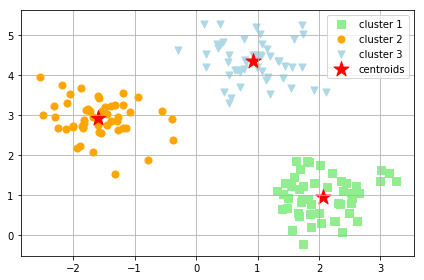

In [34]:
plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50,
            c='lightgreen',
            marker='s',
            label='cluster 1')
plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50,
            c='orange',
            marker='o',
            label='cluster 2')
plt.scatter(X[y_km == 2, 0],
            X[y_km == 2, 1],
            s=50,
            c='lightblue',
            marker='v',
            label='cluster 3')
plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s=250,
            marker='*',
            c='red',
            label='centroids')
plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig('./figures/centroids.png', dpi=300)
plt.show()

### Using the elbow method to find the optimal number of clusters

In [36]:
print('Distortion: %.2f' % km.inertia_)

Distortion: 72.48


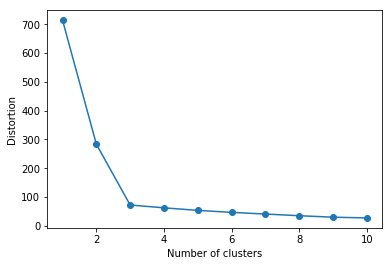

In [37]:
distortion = []
for i in range (1,11):
    km = KMeans(n_clusters=i,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
           random_state=0)
    y_km = km.fit_predict(X)
    distortion.append(km.inertia_)
plt.plot(range(1,11), distortion, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

### Quantifying the quality of clustering via silhouette plots

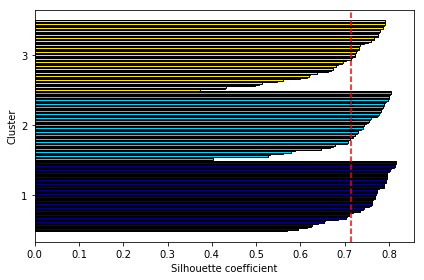

In [44]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

km = KMeans(n_clusters=3, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='black', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
# plt.savefig('./figures/silhouette.png', dpi=300)
plt.show()

## Organizing clusters as a hierarchical tree

- Hierarchical Tree
    - Agglomerative
        - Single linkage
        - Complete Linkage (see below for example)
    - Divisive  

In [46]:
import pandas as pd
import numpy as np
np.random.seed(123)
variables = ['X', 'Y', 'Z']
labels = ['ID_0', 'ID_1', 'ID_2', 'ID_3', 'ID_4']
X = np.random.random_sample([5,3])*10
df = pd.DataFrame(X, columns=variables, index=labels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


### Performing hierarchical clustering on a distance matrix

In [48]:
from scipy.spatial.distance import pdist, squareform
row_dist = pd.DataFrame(squareform(
                        pdist(df, metric='euclidean')),
                       columns=labels, index=labels)
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


In [52]:
from scipy.cluster.hierarchy import linkage
row_clusters = linkage(df.values,
                       method='complete',
                       metric='euclidean')

In [55]:
pd.DataFrame(row_clusters,
            columns=['row label 1',
                    'row label 2',
                    'distance',
                    'no. of items in clust.'],
            index=['cluster %d' % (i+1) for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


### The dendrogram

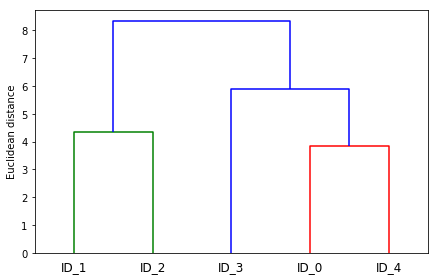

In [56]:
from scipy.cluster.hierarchy import dendrogram
row_dendr = dendrogram(row_clusters,
                      labels=labels)
plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.show()

### Attaching dendrograms to a heat map

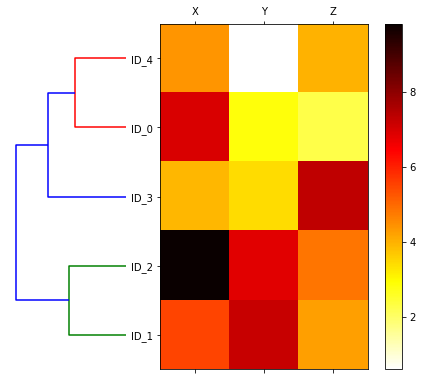

In [57]:
# plot row dendrogram
fig = plt.figure(figsize=(8, 8), facecolor='white')
axd = fig.add_axes([0.09, 0.1, 0.2, 0.6])

# note: for matplotlib < v1.5.1, please use orientation='right'
row_dendr = dendrogram(row_clusters, orientation='left')

# reorder data with respect to clustering
df_rowclust = df.ix[row_dendr['leaves'][::-1]]

axd.set_xticks([])
axd.set_yticks([])

# remove axes spines from dendrogram
for i in axd.spines.values():
        i.set_visible(False)

# plot heatmap
axm = fig.add_axes([0.23, 0.1, 0.6, 0.6])  # x-pos, y-pos, width, height
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap='hot_r')
fig.colorbar(cax)
axm.set_xticklabels([''] + list(df_rowclust.columns))
axm.set_yticklabels([''] + list(df_rowclust.index))

# plt.savefig('./figures/heatmap.png', dpi=300)
plt.show()

Note: From the dendrogram, we can conclude that if we want to cluster the samples into:  
  two groups, then it would be:  **{ID_1, ID_2}** & **{ID_0, ID_3, ID_4}**  
three groups, then it would be:  **{ID_1, ID_2}** & **{ID_3}** & **{ID_0, ID_4}**

### Implementing agglomerative clustering via scikit-learn

In [59]:
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=2,
                            affinity='euclidean',
                            linkage='complete')
labels = ac.fit_predict(X)
print('Cluster labels: %s' % labels)

Cluster labels: [0 1 1 0 0]


Note: **{ID_1, ID_2}** belong to label ```0```, **{ID_0, ID_3, ID_4}** belong to label ```1```. 

## Locating regions of high density via DBSCAN